In [1]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")

from analysis_helpers import poisson_waiting_function, \
                            run_multiple_trajectories, \
                            plot_aip_vs_t, \
                            plot_cip_vs_t, \
                            run_sensitivity_sims, \
                            extract_cips

from stochastic_simulation import StochasticSimulation
from sir_stochastic_sim import SIRStochasticSimulation
from subdivide_severity import subdivide_severity

In [2]:
# from june_realistic import base_params
# from fall_realistic_updated_age_severity import base_params as base_params
from params import ParamConfig

base_params = ParamConfig.load_config('fall', True, 'nominal')

# base_params['days_between_tests'] = 1
# base_params['test_population_fraction'] = 0.07

# No interventions (only self-reporting)

In [3]:
# run 1 trajectory
params = base_params.copy()
# params['days_between_tests'] = 300
# params['perform_contact_tracing'] = False
np.random.seed(15)
dfs_sims = run_multiple_trajectories(params, ntrajectories=1, time_horizon=112)

,S,QS,QI,R,E_0,E_1,E_2,E_3,pre_ID_0,pre_ID_1,...,SyID_severe_16,SyID_severe_17,SyID_severe_18,SyID_severe_19,cumulative_mild,cumulative_severe,severity_0,severity_1,severity_2,severity_3
0,34224,0,0,0,0,0,0,0,0,0,...,1,0,0,0,2,2,2,1.95081,0.0360316,0.0131601
1,34191,22,12,2,3,2,2,3,0,0,...,0,0,0,0,19,11,19,10.7294,0.198174,0.0723805
2,34104,96,35,3,3,4,3,3,0,0,...,0,0,0,0,38,22,38,21.4589,0.396348,0.144761
3,34042,141,54,4,4,5,1,6,0,0,...,0,1,0,0,50,36,50,35.1145,0.648569,0.236882
4,34022,144,61,7,6,6,2,3,0,0,...,1,0,1,0,59,47,59,45.844,0.846743,0.309262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,34039,83,0,188,0,0,0,0,0,0,...,0,0,0,0,102,86,102,83.8848,1.54936,0.565884
109,34030,92,0,188,0,0,0,0,0,0,...,0,0,0,0,102,86,102,83.8848,1.54936,0.565884
110,34031,91,0,188,0,0,0,0,0,0,...,0,0,0,0,102,86,102,83.8848,1.54936,0.565884
111,34020,102,0,188,0,0,0,0,0,0,...,0,0,0,0,102,86,102,83.8848,1.54936,0.565884


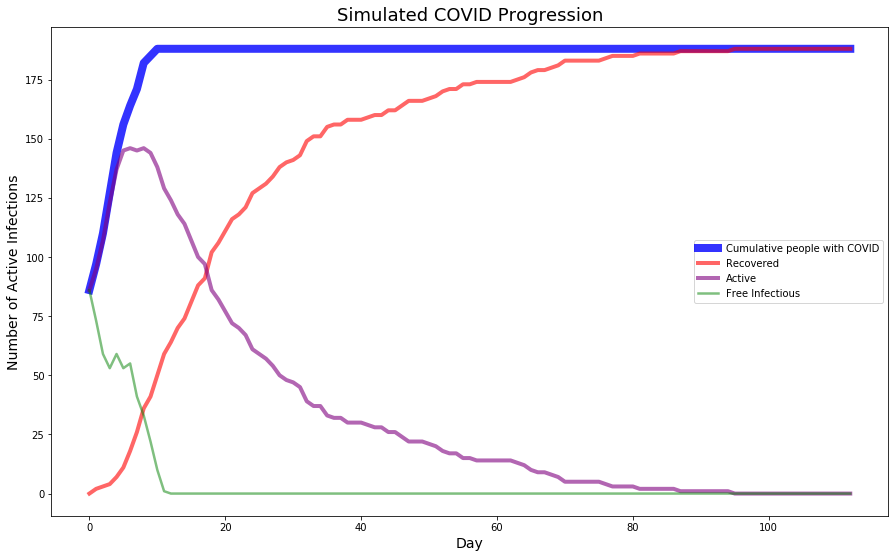

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,9))
df_0 = dfs_sims[0]
# Plotting
cumulative_cols = ['QI','R'] + ['E_{}'.format(x) for x in range(params['max_time_exposed'])] + \
                ['ID_{}'.format(x) for x in range(params['max_time_ID'])] + \
                ['pre_ID_{}'.format(x) for x in range(params['max_time_pre_ID'])] + \
                ['SyID_mild_{}'.format(x) for x in range(params['max_time_SyID_mild'])] + \
                ['SyID_severe_{}'.format(x) for x in range(params['max_time_SyID_severe'])]
recovered_cols = ['R']
active_cols = ['QI'] + ['E_{}'.format(x) for x in range(params['max_time_exposed'])] + \
                ['ID_{}'.format(x) for x in range(params['max_time_ID'])] + \
                ['pre_ID_{}'.format(x) for x in range(params['max_time_pre_ID'])] + \
                ['SyID_mild_{}'.format(x) for x in range(params['max_time_SyID_mild'])] + \
                ['SyID_severe_{}'.format(x) for x in range(params['max_time_SyID_severe'])]
free_infectious = ['ID_{}'.format(x) for x in range(params['max_time_ID'])] + \
                ['pre_ID_{}'.format(x) for x in range(params['max_time_pre_ID'])] + \
                ['SyID_mild_{}'.format(x) for x in range(params['max_time_SyID_mild'])] + \
                ['SyID_severe_{}'.format(x) for x in range(params['max_time_SyID_severe'])]
plt.plot(df_0[cumulative_cols].sum(axis=1), linewidth=8.0, alpha=0.8, color='blue')
plt.plot(df_0[recovered_cols].sum(axis=1), linewidth=4.0, alpha=0.6, color='red')
plt.plot(df_0[active_cols].sum(axis=1), linewidth=4.0, alpha=0.6, color='purple')
plt.plot(df_0[free_infectious].sum(axis=1), linewidth=2.5, alpha=0.5, color='green')
plt.xlabel("Day", size=14)
plt.ylabel("Number of Active Infections", size=14)
plt.title('Simulated COVID Progression', size=18)
plt.legend(('Cumulative people with COVID', 'Recovered', 'Active', 'Free Infectious'), loc='best')
df_0

# Different Metrics

Text(0, 0.5, 'Cumulative People in each severity class')

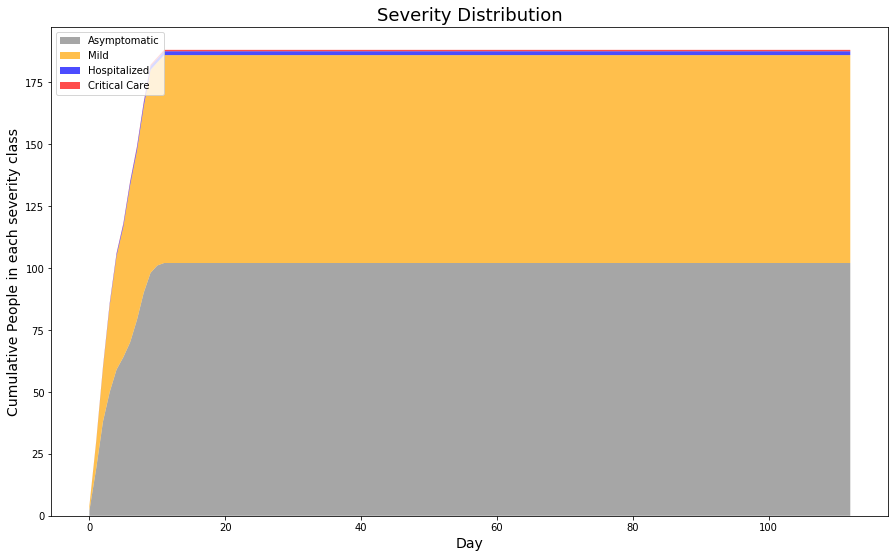

In [5]:
# Metric: Area graph of the number of people in each severity state
plt.figure(figsize=(15,9))
y0 = list(df_0['severity_0'])
y1 = list(df_0['severity_1'])
y2 = list(df_0['severity_2'])
y3 = list(df_0['severity_3'])
x = list(range(len(list(df_0['severity_0']))))

plt.stackplot(x, y0,y1,y2,y3, labels=['Asymptomatic','Mild','Hospitalized','Critical Care'], alpha=0.7, colors=['grey', 'orange', 'blue', 'red']*10)
plt.legend(loc='upper left')
plt.title('Severity Distribution', size=18)
plt.xlabel('Day', size=14)
plt.ylabel('Cumulative People in each severity class', size=14)

# print(list(df_0['severity_0']), list(df_0['severity_1']), list(df_0['severity_2']), list(df_0['severity_3']))
# print(list(range(len(list(df_0['severity_0'])))))

# Multiple Trajectories

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 12

def plot_trajectories(dfs, title, params, columns, color='green'):
    plt.xlabel("Day")
    plt.ylabel("Number of Cumulative Infections")
    plt.title(title)
    for df in dfs:
        add_plot(df, params, columns, color=color)

def add_plot(df, params, columns, color='blue'):
    cols = columns
    plt.plot(df[cols].sum(axis=1), linewidth=10.0, alpha=0.1, color=color)

In [7]:
np.random.seed(15)
dfs_sims = run_multiple_trajectories(params, ntrajectories=200, time_horizon=112)

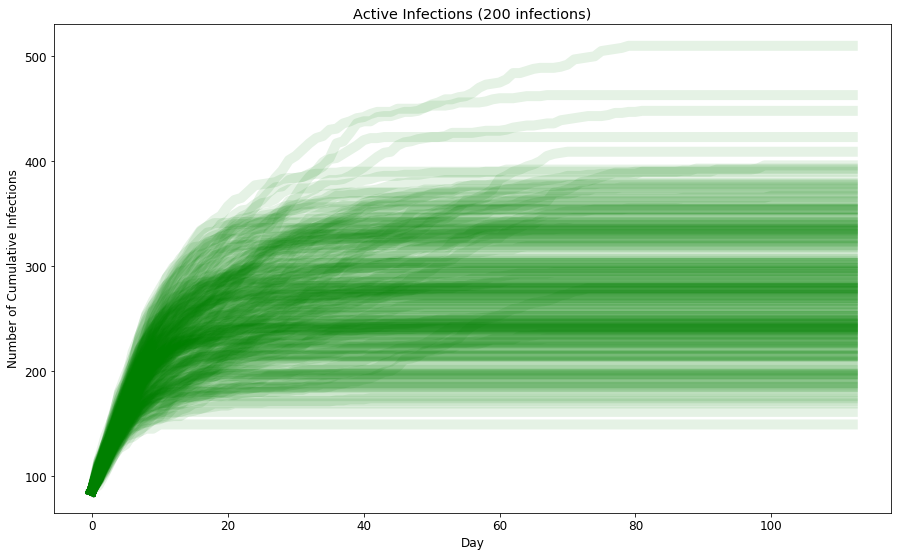

In [8]:
plt.figure(figsize=(15,9))
plot_trajectories(dfs_sims, 'Active Infections ({:d} infections)'.format(200), base_params, cumulative_cols)

In [9]:
cum_infections = list()
for sim in dfs_sims:
#     print(int(np.sum(sim.tail(1)[cumulative_cols], axis=1)))
    cum_infections.append(int(np.sum(sim.tail(1)[cumulative_cols], axis=1)))

Text(0.5, 1.0, 'Distribution of Cumulative Infections (n=200)')

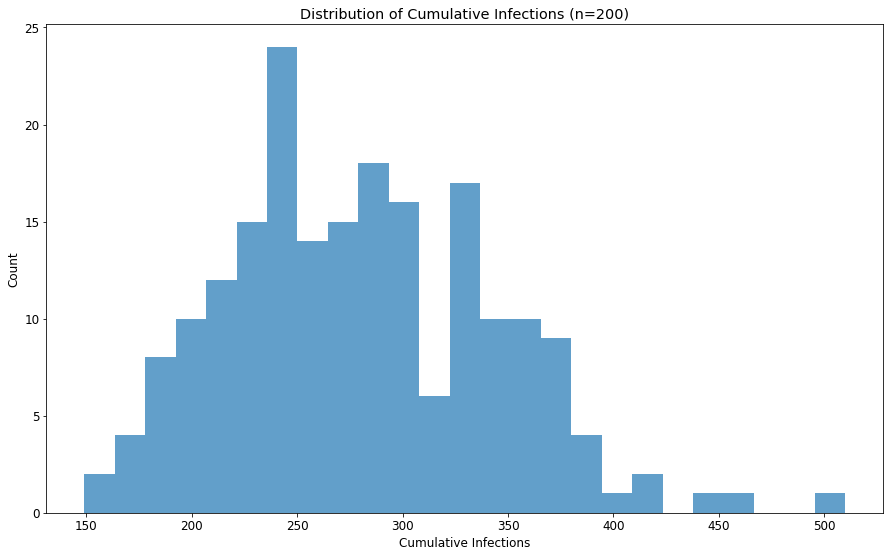

In [10]:
plt.figure(figsize=(15,9))
plt.hist(cum_infections, density=False, alpha=0.7, bins=25)
plt.xlabel('Cumulative Infections')
plt.ylabel('Count')
plt.title('Distribution of Cumulative Infections (n={:d})'.format(200))

# Stacked Bar Plot

In [11]:
cum_sev_0 = list()
cum_sev_1 = list()
cum_sev_2 = list()
cum_sev_3 = list()
for sim in dfs_sims:
#     print(int(np.sum(sim.tail(1)[cumulative_cols], axis=1)))
    cum_sev_0.append(sim.tail(1)["severity_0"])
    cum_sev_1.append(sim.tail(1)["severity_1"])
    cum_sev_2.append(sim.tail(1)["severity_2"])
    cum_sev_3.append(sim.tail(1)["severity_3"])

# Other Analyses
# What if social distancing is less effective (25 % more contacts per day)?

In [6]:
# run 1 trajectory
params['expected_contacts_per_day'] = 1.25 * params['expected_contacts_per_day']
np.random.seed(15)
dfs_sims = run_multiple_trajectories(params, ntrajectories=1, time_horizon=112)

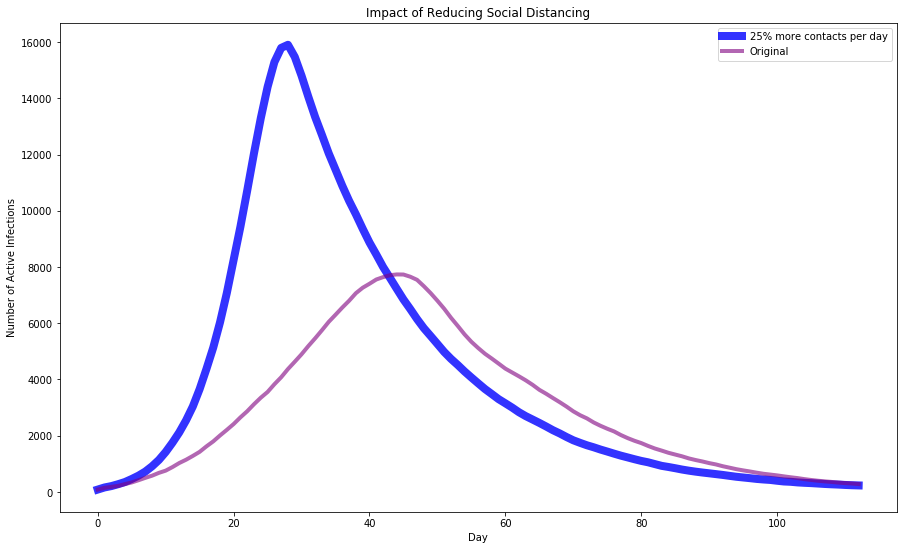

In [7]:
plt.figure(figsize=(15,9))
df_1 = dfs_sims[0]
plt.plot(df_1[active_cols].sum(axis=1), linewidth=8.0, alpha=0.8, color='blue')
plt.plot(df_0[active_cols].sum(axis=1), linewidth=4.0, alpha=0.6, color='purple')
plt.xlabel("Day")
plt.ylabel("Number of Active Infections")
plt.title('Impact of Reducing Social Distancing')
plt.legend(('25% more contacts per day', 'Original'), loc='best')

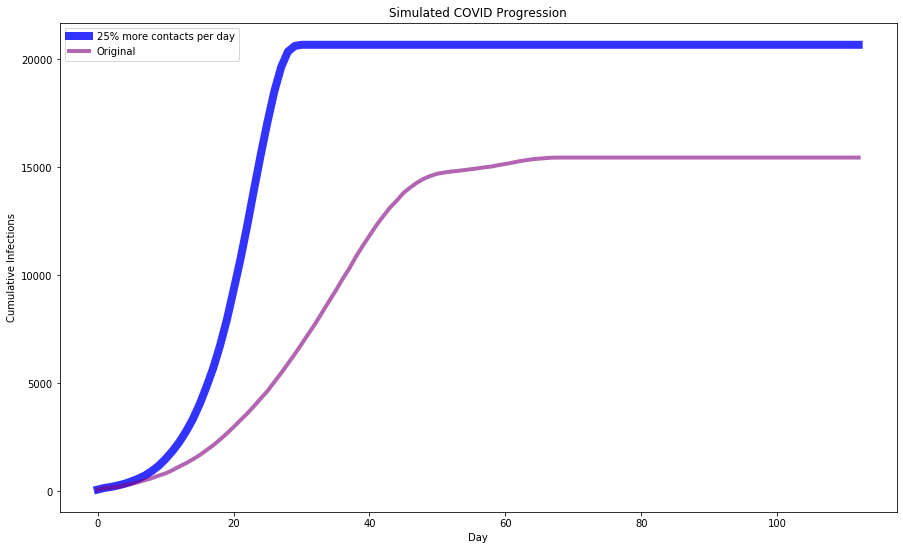

In [8]:
plt.figure(figsize=(15,9))
df_1 = dfs_sims[0]
plt.plot(df_1[cumulative_cols].sum(axis=1), linewidth=8.0, alpha=0.8, color='blue')
plt.plot(df_0[cumulative_cols].sum(axis=1), linewidth=4.0, alpha=0.6, color='purple')
plt.xlabel("Day")
plt.ylabel("Cumulative Infections")
plt.title('Simulated COVID Progression')
plt.legend(('25% more contacts per day', 'Original'), loc='best')

# What about with Contact Tracing?

In [10]:
params = base_params.copy()
params['perform_contact_tracing'] = True

# run 1 trajectory
np.random.seed(15)
dfs_sims = run_multiple_trajectories(params, ntrajectories=1, time_horizon=150)

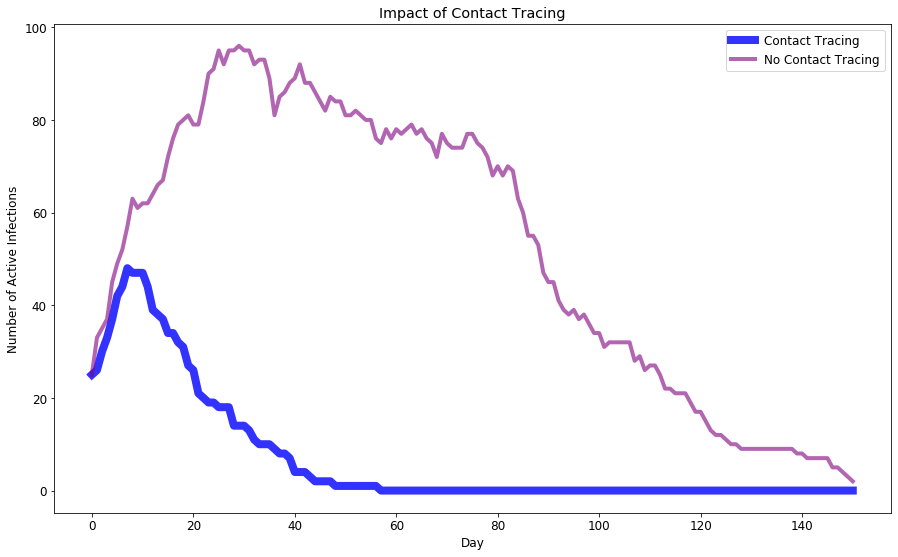

In [11]:
df_ct = dfs_sims[0]
plt.figure(figsize=(15,9))
# df_1 = dfs_sims[0]
plt.plot(df_ct[active_cols].sum(axis=1), linewidth=8.0, alpha=0.8, color='blue')
plt.plot(df_0[active_cols].sum(axis=1), linewidth=4.0, alpha=0.6, color='purple')
plt.xlabel("Day")
plt.ylabel("Number of Active Infections")
plt.title('Impact of Contact Tracing')
plt.legend(('Contact Tracing', 'No Contact Tracing'), loc='best')

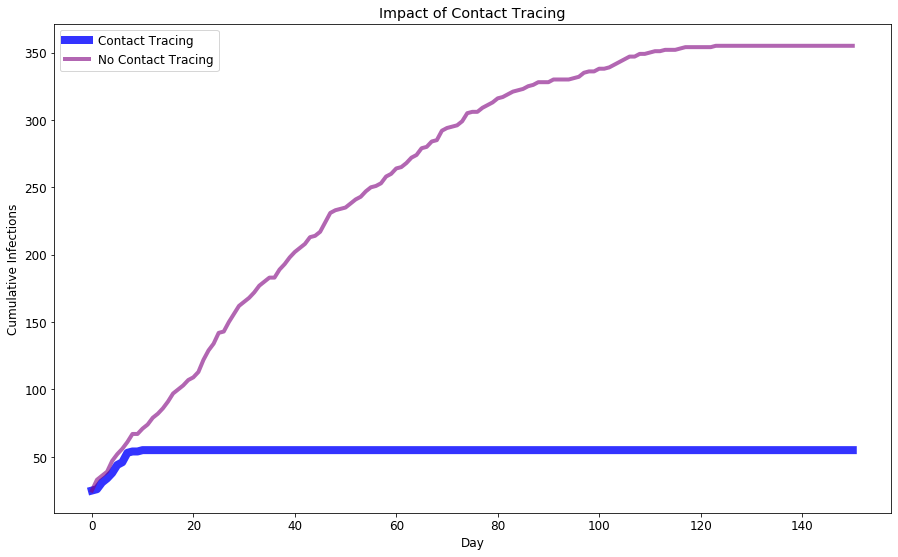

In [13]:
df_ct = dfs_sims[0]
plt.figure(figsize=(15,9))
# df_1 = dfs_sims[0]
plt.plot(df_ct[cumulative_cols].sum(axis=1), linewidth=8.0, alpha=0.8, color='blue')
plt.plot(df_0[cumulative_cols].sum(axis=1), linewidth=4.0, alpha=0.6, color='purple')
plt.xlabel("Day")
plt.ylabel("Cumulative Infections")
plt.title('Impact of Contact Tracing')
plt.legend(('Contact Tracing', 'No Contact Tracing'), loc='best')

# Cumulative Severity: Multiple trajectories

In [36]:
# run 1 trajectory
params = base_params.copy()
np.random.seed(15)
dfs_sims = run_multiple_trajectories(params, ntrajectories=5, time_horizon=150)

Text(0, 0.5, 'Cumulative People in each severity class')

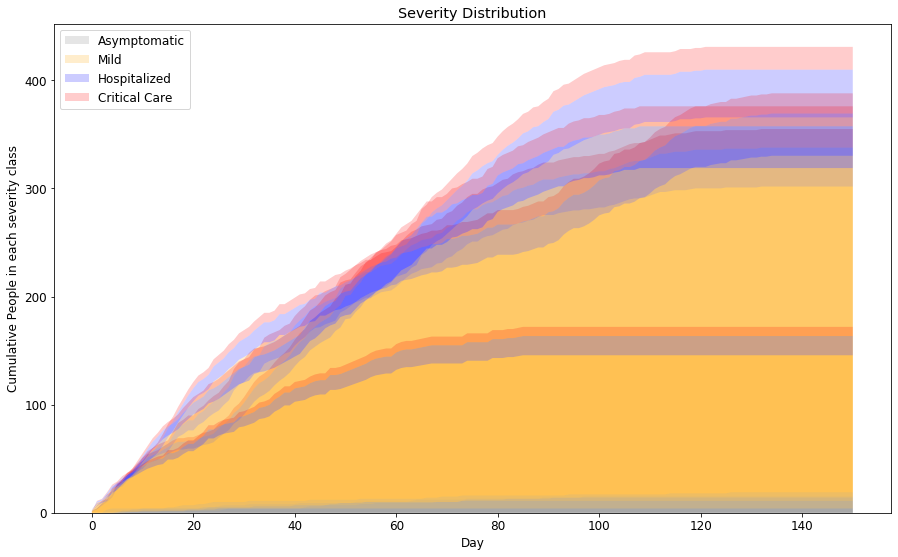

In [38]:
# Metric: Area graph of the number of people in each severity state
plt.figure(figsize=(15,9))

legend = False
for df in dfs_sims:
    y0 = list(df['severity_0'])
    y1 = list(df['severity_1'])
    y2 = list(df['severity_2'])
    y3 = list(df['severity_3'])
    x = list(range(len(list(df['severity_0']))))

    plt.stackplot(x, y0,y1,y2,y3, labels=['Asymptomatic','Mild','Hospitalized','Critical Care'], alpha=0.2, colors=['grey', 'orange', 'blue', 'red']*10)
    if legend == False:
        plt.legend(loc='upper left')
        legend = True

plt.title('Severity Distribution')
plt.xlabel('Day')
plt.ylabel('Cumulative People in each severity class')

# dfs_sims[0]
# dfs_sims[1]

# print(list(df_0['severity_0']), list(df_0['severity_1']), list(df_0['severity_2']), list(df_0['severity_3']))
# print(list(range(len(list(df_0['severity_0'])))))

In [16]:
# run 1 trajectory
params = base_params.copy()
np.random.seed(15)
dfs_sims = run_multiple_trajectories(params, ntrajectories=5, time_horizon=112)
params['days_between_tests'] = 300
# params['perform_contact_tracing'] = False